<h1 align='Center'>
<img src="https://assets.digihaul.com/images/logo.png" width="350" height="550" align="center"/>
</h1>
<h3 align='center'> Task 1</h3>

### Problem Statement

Road haulage is essential for the people and businesses of the UK. Approximately 90% of all goods transported by land in Great Britain are moved directly by road. DigiHaul is a digital transport business, specialising in managing, consolidating and integrating data from both Carriers and Shippers to deliver seamless end-to-end logistics service.
Shippers book shipments on the DigiHaul platform, detailing the scheduled collection and delivery time windows / locations and required vehicle types for carriers to consider. Once a carrier accepts a job and collection is scheduled, DigiHaul’s driver app facilitates real-time tracking of shipments through GPS signals, subject to carriers granting permissions for location logging.


In [4]:
# Importing data handling python packages

import pandas as pd
import re
import googlemaps
import numpy as np
from math import radians
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import DistanceMetric

dist = DistanceMetric.get_metric("haversine")

warnings.filterwarnings("ignore")

/Users/karthicksundar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/karthicksundar/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


### Input data:

Three datasets are provided for working with the tasks and each one of them are in .csv format

1. gps_data.csv: contains GPS logging(latitude and longitude) for each shipment along with the timestamp details

2. shipment.csv: contains all the details about each shipment initiated, with the details of shipper, details of carries, collection and delivery - postcode, latitude, longitude and time


In [5]:
# reading in input datasets

gps_data = pd.read_csv("./Test/GPS_data.csv")
shipment = pd.read_csv("./Test/Shipment_bookings.csv")

### Pre-processing:

1. Time stamp formatting: time-stamp details captured by the system are not in a recognizable format for the python to handle and hence it is converted to suit python needs

2. Datatype conversion: all the shipment numbers are type casted to 'string' data type for sanitary reasons

3. Missing data: Records with no GPS details(latitude and longitude measures missing) are removed from the datset

In [6]:
#### Formatting time-stamp columns and performing datatype conversion


def format_time_stamp(input_col_name, output_col_name, file):
    """
    Function to format the input time stamp to python understandable format
    Args:
        input_col_name (str): name of input column with time-stamp
        output_col_name(str): name of new output column to fill the generated output
        file           (str): file name to chose the correct dataframe to use
    Returns:
        Changes the dataframes with new columns
    """
    if file == "gps":
        gps_data[output_col_name] = pd.to_datetime(
            gps_data[input_col_name].apply(
                lambda x: (
                    re.sub("T", " ", x[:-9])
                    if "Z" not in x
                    else re.sub("T", " ", x[:-5])
                )
            )
        )
    else:
        shipment[output_col_name] = pd.to_datetime(
            shipment[input_col_name].apply(
                lambda x: (
                    re.sub("T", " ", x[:-9])
                    if "Z" not in x
                    else re.sub("T", " ", x[:-5])
                )
            )
        )


format_time_stamp("RECORD_TIMESTAMP", "FORMATTED_GPS_TIMESTAMP", "gps")
format_time_stamp(
    "LAST_DELIVERY_SCHEDULE_LATEST", "FORMATTED_DELIVERY_SCHEDULE_LATEST", "shipment"
)
format_time_stamp(
    "LAST_DELIVERY_SCHEDULE_EARLIEST",
    "FORMATTED_DELIVERY_SCHEDULE_EARLIEST",
    "shipment",
)
format_time_stamp(
    "FIRST_COLLECTION_SCHEDULE_LATEST", "FROMATTED_FIRST_COLLECTION_LATEST", "shipment"
)
format_time_stamp(
    "FIRST_COLLECTION_SCHEDULE_EARLIEST",
    "FROMATTED_FIRST_COLLECTION_EARLIEST",
    "shipment",
)


# datatype conversion
shipment["SHIPMENT_NUMBER"] = shipment["SHIPMENT_NUMBER"].astype("str")
gps_data["SHIPMENT_NUMBER"] = gps_data["SHIPMENT_NUMBER"].astype("str")


# removing shipments were LAT LON details are not logged in GPS data
gps_data = gps_data[gps_data["LON"] != 0.0]

## Task 1 

Operational teams rely heavily on KPIs like on-time collection and on-time delivery to gauge carrier performance. What percentage of shipments met the on-time delivery threshold (arriving no later than 30 minutes past the scheduled delivery window) between October 1st and December 31st, 2023? Please outline your assumptions.


Steps:
1. Assumptions and application of "time filter" on data 
2. Assumptions on delivery details from "GPS" data
3. Data transformation from GPS and delivery data
4. Calculation of distance matric on GPS data
5. Assumptions and heuristics on distance threshold for delivery
6. Calculation of delivery time and validation against delivery threshold
7. Profiling the delivery data based on distance and time heuristics 
8. Calculating percentage of shipments met the on-time delivery threshold

### Step 1:  Assumptions and application of "time filter" on data  

There are total 3245 unique shipments in the given dataset

- Assumption 1: Date filter on the schedule (before carrier starts)
                - time frame of 3 months on the FIRST_COLLECTION_EARLIEST
                - there are 1 shipments which got excluded are ('SEZHUK-230928-24836')
                - SEZHUK-230928-24836: collection earliest is 29-09-2023 (before the given window start time)
                - with the above assumption and date filter: there are 3244 shipments fall under this timeframe

- Assumption 2: time frame of 3 months on the FIRST_DELIVERY_LATEST
                - there are 7 shipments which got excluded
                - with the above assumption and date filter: there are 3238 shipments fall under this timeframe

Since it makes more sense to consider all deliveries within the delivery latest time period, going with "Assumption 2"

In [7]:
# Timeframe filter

# Assumption 1
# time_frame = ((shipment['FROMATTED_FIRST_COLLECTION_EARLIEST'] < '2023-10-01') |
#                 (shipment['FROMATTED_FIRST_COLLECTION_EARLIEST'] >= '2024-01-1'))
# shipment = shipment.loc[time_frame]
# print(shipment)


# Assumption 2:

# time_frame = ((shipment['FORMATTED_DELIVERY_SCHEDULE_LATEST'] < '2023-10-01') |
#                 (shipment['FORMATTED_DELIVERY_SCHEDULE_LATEST'] >= '2024-01-1'))
# shipment = shipment.loc[time_frame]
# print(shipment)


# Proceeding with "Assumption 2"
time_frame = (shipment["FORMATTED_DELIVERY_SCHEDULE_LATEST"] >= "2023-10-01") & (
    shipment["FORMATTED_DELIVERY_SCHEDULE_LATEST"] < "2024-01-01"
)
shipment = shipment.loc[time_frame]

### Step 2:  Assumptions on delivery details from "GPS" data

Assumption: 
    
    Inorder to calculate the delay in delivery we consider the last entry on GPS to be final delivery time and end point. The below table reads the first row as "153 shipments has one GPS log in the GPS file, 99 shipments has 2 GPS logs and so on.

Note: we will later validation if the shipments with very few logs are insightful

In [8]:
gps_logs_summary = (
    gps_data.groupby("SHIPMENT_NUMBER")["SHIPMENT_NUMBER"]
    .count()
    .sort_values()
    .reset_index(name="no.of logs")
)
gps_logs_summary.groupby("no.of logs")["SHIPMENT_NUMBER"].nunique().reset_index(
    name="no.of shipments"
)

,no.of logs,no.of shipments
0,1,153
1,2,99
2,3,48
3,4,44
4,5,34
...,...,...
608,3239,1
609,3309,1
610,3687,1
611,4220,1


In [9]:
gps_logs_summary.groupby("no.of logs")["SHIPMENT_NUMBER"].nunique().reset_index(
    name="no.of shipments"
).to_csv("gps_logs_distribution.csv")

### Step 3:  Data transformation from GPS and delivery data

- For every shipment entry in the date fileterd dataset, we filter the latest GPS record with respect to time-stamp from the GPS file

- Both the GPS and the shipment data are joined together as single dataframe

In [10]:
# get final gps location as delivery timestamp (assumption)
delivery_log_df = pd.DataFrame(
    gps_data.groupby("SHIPMENT_NUMBER").agg(
        {"FORMATTED_GPS_TIMESTAMP": "max", "LAT": "last", "LON": "last"}
    )
).reset_index()

# merging actual and expected delivery details
delivery_log_df = delivery_log_df.merge(shipment, how="inner", on="SHIPMENT_NUMBER")[
    [
        "SHIPMENT_NUMBER",
        "FORMATTED_GPS_TIMESTAMP",
        "PROJECT_ID",
        "LAT",
        "LON",
        "LAST_DELIVERY_LATITUDE",
        "LAST_DELIVERY_LONGITUDE",
        "FORMATTED_DELIVERY_SCHEDULE_EARLIEST",
        "FORMATTED_DELIVERY_SCHEDULE_LATEST",
    ]
]

In [11]:
len(delivery_log_df)

3236

### Step 4: Calculation of distance matric on GPS data

Inorder to work with the GPS details (latitude and longitude) and make sense of the shipment movement, we need to calculate the distance between the current log and the set delivery expected time.

Haversine distance is one such measuring technique to calculate the distance which is used from sklean package
Google distance API is another option to get the distance matric via API call (which is shown in Task 2 solutions)

In [12]:
# Calculate the distance between the GPS location and the delivery location

R = 6373.0  # approx radius of earth in km


def haversine(x):
    X = [
        [radians(x["LAT"]), radians(x["LON"])],
        [radians(x["LAST_DELIVERY_LATITUDE"]), radians(x["LAST_DELIVERY_LONGITUDE"])],
    ]
    distance_sklearn = R * dist.pairwise(X)
    return np.array(distance_sklearn).item(1)


delivery_log_df["HAVERSINE_DISTANCE"] = delivery_log_df.apply(
    lambda x: haversine(x), axis=1
)
delivery_log_df["LAT_DIFF"] = (
    delivery_log_df["LAST_DELIVERY_LATITUDE"] - delivery_log_df["LAT"]
)
delivery_log_df["LON_DIFF"] = (
    delivery_log_df["LAST_DELIVERY_LONGITUDE"] - delivery_log_df["LON"]
)

### Step 5: Assumptions and heuristics on distance threshold for delivery

Analysis has been conducted to determine the inclusion of logs which are,
    
    - almost at the delivery location
    - already reached the delivery location
    - to avoid errors in the GPS reading
    
Different thresholds are set from 1km to 10km and their successful deliveries are evaluated. Finally the graph shows that "2km" threshold holds the max number of successes in delivery and plateaus till 10km with only slight changes.

In [13]:
# to create an indicator if the last row of logs is around 2km or 0.02 diff in latitide and longitude atleast around teh delivery destination
delivery_log_df["AROUND_DESTINATION?"] = delivery_log_df.apply(
    lambda x: (
        "Yes"
        if (x["HAVERSINE_DISTANCE"] < 2)
        and (x["LAT_DIFF"] < 0.02)
        and (x["LON_DIFF"] < 0.02)
        else "No"
    ),
    axis=1,
)

### Step 6:  Calculation of delivery time and validation against delivery threshold

Delivery time: difference between expected delivery time and the current GPS time-stamp and then converted to hours

Heuristic: based on the given details, delivery is considered successfull if it was delivered by the expected time +30mins

In [14]:
delivery_log_df

,SHIPMENT_NUMBER,FORMATTED_GPS_TIMESTAMP,PROJECT_ID,LAT,LON,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FORMATTED_DELIVERY_SCHEDULE_EARLIEST,FORMATTED_DELIVERY_SCHEDULE_LATEST,HAVERSINE_DISTANCE,LAT_DIFF,LON_DIFF,AROUND_DESTINATION?
0,SEZHUK-230918-245388,2023-10-11 11:50:00,3244246f-e37c-4ba4-b9b3-61416a4449ae,52.277015,-8.276215,52.276579,-8.258109,2023-10-10 11:25:00,2023-10-10 11:55:00,1.233151,-0.000436,0.018106,Yes
1,SEZHUK-230919-245487,2023-11-30 15:59:00,98d76108-ba01-441a-8425-641afdb920fb,53.260643,-1.318575,53.258602,-1.320728,2023-11-30 15:30:00,2023-11-30 16:00:00,0.268415,-0.002041,-0.002153,Yes
2,SEZHUK-230919-245488,2023-10-12 13:08:00,98d76108-ba01-441a-8425-641afdb920fb,53.259834,-1.319917,53.258602,-1.320728,2023-10-12 15:30:00,2023-10-12 16:00:00,0.147250,-0.001232,-0.000811,Yes
3,SEZHUK-230919-245489,2023-11-09 17:51:00,98d76108-ba01-441a-8425-641afdb920fb,52.907932,-1.462328,53.258602,-1.320728,2023-11-09 17:00:00,2023-11-09 19:00:00,40.135800,0.350670,0.141600,No
4,SEZHUK-230919-245490,2023-11-02 16:29:00,98d76108-ba01-441a-8425-641afdb920fb,53.260650,-1.318117,53.258602,-1.320728,2023-11-02 17:00:00,2023-11-02 19:00:00,0.286499,-0.002048,-0.002611,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,SEZHUK-231228-277315,2023-12-30 09:41:00,2aac1ee1-5cab-42c8-9d2f-ec995a63c14f,51.418861,-0.982089,53.295391,-1.066283,2023-12-29 14:30:00,2023-12-29 15:00:00,208.804408,1.876530,-0.084194,No
3232,SEZHUK-231228-277382,2023-12-29 19:31:00,2aac1ee1-5cab-42c8-9d2f-ec995a63c14f,53.294049,-1.066074,53.295391,-1.066283,2023-12-29 18:30:00,2023-12-29 19:00:00,0.149886,0.001342,-0.000209,Yes
3233,SEZHUK-231228-277383,2023-12-29 21:52:00,2aac1ee1-5cab-42c8-9d2f-ec995a63c14f,52.961624,-1.269986,53.295391,-1.066283,2023-12-29 22:30:00,2023-12-29 23:00:00,39.535788,0.333767,0.203703,No
3234,SEZHUK-231228-277384,2023-12-29 18:27:00,2aac1ee1-5cab-42c8-9d2f-ec995a63c14f,53.293600,-1.065493,53.295391,-1.066283,2023-12-29 17:30:00,2023-12-29 18:00:00,0.206014,0.001791,-0.000790,Yes


In [15]:
# calculating the delay in the delivery if any
delivery_log_df["DELIVERY_DELAY_IN_SECS"] = (
    delivery_log_df["FORMATTED_DELIVERY_SCHEDULE_LATEST"]
    - delivery_log_df["FORMATTED_GPS_TIMESTAMP"]
)

delivery_log_df["DELIVERY_DELAY_IN_HRS"] = (
    delivery_log_df["DELIVERY_DELAY_IN_SECS"].dt.total_seconds() / 3600
)
delivery_log_df["DELIVERED_LATE_BY_TIME?"] = delivery_log_df[
    "DELIVERY_DELAY_IN_HRS"
].apply(lambda x: "Yes" if x < -0.50 else "No")

### Step 7: Profiling the delivery data based on distance and time heuristics 


1. Advanced delivery: No of shipements delivered before the threshold time
2. Threshold delivery: No of shipments delivered during the period of expected-delivery-time+30mins(threshold time)
3. Late delivert: No of shipments delivered after the threhsold time
4. Incomplete logs before threshold time: No of shipment whose logs are unavailable after a point and before reaching threshold time. There are not so useful details and need to be neglected
5. Imcomplete logs in and post threshold time: No of shipment whoes logs are imcomplete in threshold period or later. They are "Potential delayed" shipments and need to be considered

In [16]:
advanced_delivery = delivery_log_df[
    (delivery_log_df["DELIVERY_DELAY_IN_HRS"] > 0.0)
    & ((delivery_log_df["AROUND_DESTINATION?"] == "Yes"))
]
advanced_delivery["INDICATOR"] = "advanced_delivery"
print("No of shipments delivered WELL before time:", len(advanced_delivery))

threshold_delivery = delivery_log_df[
    (delivery_log_df["DELIVERY_DELAY_IN_HRS"] >= -0.5)
    & (delivery_log_df["DELIVERY_DELAY_IN_HRS"] <= 0.0)
    & ((delivery_log_df["AROUND_DESTINATION?"] == "Yes"))
]
threshold_delivery["INDICATOR"] = "threshold_delivery"
print("No of shipments delivered WITHIN delivery threshold:", len(threshold_delivery))

late_delivery = delivery_log_df[
    (delivery_log_df["DELIVERY_DELAY_IN_HRS"] < -0.5)
    & ((delivery_log_df["AROUND_DESTINATION?"] == "Yes"))
]
late_delivery["INDICATOR"] = "late_delivery"
print("No of shipments delivered late and within 2km:", len(late_delivery))


incomplete_logs_before_threshold = delivery_log_df[
    (delivery_log_df["DELIVERY_DELAY_IN_HRS"] > 0.0)
    & ((delivery_log_df["AROUND_DESTINATION?"] == "No"))
]
incomplete_logs_before_threshold["INDICATOR"] = "incomplete_logs_before_threshold"
print(
    "No of shipments with log capturing stopped before the delivery threshold:",
    len(incomplete_logs_before_threshold),
)

incomplete_logs_potential_delay = delivery_log_df[
    (delivery_log_df["DELIVERY_DELAY_IN_HRS"] <= 0.0)
    & ((delivery_log_df["AROUND_DESTINATION?"] == "No"))
]
incomplete_logs_potential_delay["INDICATOR"] = "incomplete_logs_potential_delay"
print(
    "No of shipments with logs capturing stopped on and after the delivery threshold (POTENTIAL DELAY):",
    len(incomplete_logs_potential_delay),
)

No of shipments delivered WELL before time: 1139
No of shipments delivered WITHIN delivery threshold: 194
No of shipments delivered late and within 2km: 654
No of shipments with log capturing stopped before the delivery threshold: 572
No of shipments with logs capturing stopped on and after the delivery threshold (POTENTIAL DELAY): 677


In [17]:
valid_data = pd.concat(
    [
        advanced_delivery,
        threshold_delivery,
        late_delivery,
        incomplete_logs_potential_delay,
    ]
).reset_index(drop=True)
valid_data.to_csv("shipment_gps_data.csv")

In [18]:
shipment_gps_data = pd.read_csv("shipment_gps_data.csv")
print(len(shipment_gps_data))

2664


### Step 8: Calculating percentage of shipments met the on-time delivery threshold

In [27]:
successful_deliveries

1333

In [26]:
total_shipments = len(delivery_log_df) - len(incomplete_logs_before_threshold)

successful_deliveries = len(advanced_delivery) + len(threshold_delivery)

print(
    f"%of shipments delivered on time is {round(successful_deliveries*100/total_shipments,2)}%"
)

%of shipments delivered on time is 50.04%


#### --------------------  Analysis to identify the distance threshold --------------------

<BarContainer object of 6 artists>

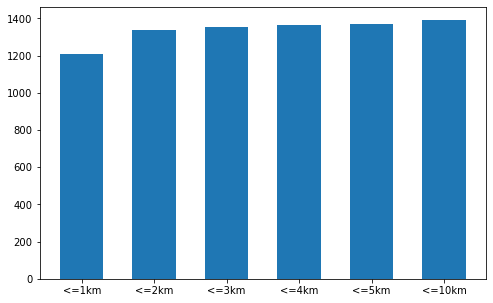

In [31]:
# to create an indicator if the last row of logs is around 2km or 0.02 diff in latitide and longitude atleast around teh delivery destination
delivery_log_df["DELIVERY_STATUS_1?"] = delivery_log_df.apply(
    lambda x: (
        "Yes"
        if (x["HAVERSINE_DISTANCE"] <= 1) and (x["DELIVERED_LATE_BY_TIME?"] == "No")
        else "No"
    ),
    axis=1,
)

delivery_log_df["DELIVERY_STATUS_2?"] = delivery_log_df.apply(
    lambda x: (
        "Yes"
        if (x["HAVERSINE_DISTANCE"] <= 2) and (x["DELIVERED_LATE_BY_TIME?"] == "No")
        else "No"
    ),
    axis=1,
)

delivery_log_df["DELIVERY_STATUS_3?"] = delivery_log_df.apply(
    lambda x: (
        "Yes"
        if (x["HAVERSINE_DISTANCE"] <= 3) and (x["DELIVERED_LATE_BY_TIME?"] == "No")
        else "No"
    ),
    axis=1,
)

delivery_log_df["DELIVERY_STATUS_4?"] = delivery_log_df.apply(
    lambda x: (
        "Yes"
        if (x["HAVERSINE_DISTANCE"] <= 4) and (x["DELIVERED_LATE_BY_TIME?"] == "No")
        else "No"
    ),
    axis=1,
)

delivery_log_df["DELIVERY_STATUS_5?"] = delivery_log_df.apply(
    lambda x: (
        "Yes"
        if (x["HAVERSINE_DISTANCE"] <= 5) and (x["DELIVERED_LATE_BY_TIME?"] == "No")
        else "No"
    ),
    axis=1,
)

delivery_log_df["DELIVERY_STATUS_10?"] = delivery_log_df.apply(
    lambda x: (
        "Yes"
        if (x["HAVERSINE_DISTANCE"] <= 10) and (x["DELIVERED_LATE_BY_TIME?"] == "No")
        else "No"
    ),
    axis=1,
)

plot_data = [
    ["<=1km", len(delivery_log_df[delivery_log_df["DELIVERY_STATUS_1?"] == "Yes"])],
    ["<=2km", len(delivery_log_df[delivery_log_df["DELIVERY_STATUS_2?"] == "Yes"])],
    ["<=3km", len(delivery_log_df[delivery_log_df["DELIVERY_STATUS_3?"] == "Yes"])],
    ["<=4km", len(delivery_log_df[delivery_log_df["DELIVERY_STATUS_4?"] == "Yes"])],
    ["<=5km", len(delivery_log_df[delivery_log_df["DELIVERY_STATUS_5?"] == "Yes"])],
    ["<=10km", len(delivery_log_df[delivery_log_df["DELIVERY_STATUS_10?"] == "Yes"])],
]

plot_df = pd.DataFrame(plot_data, columns=["Haversine distance", "#Deliveries on time"])

plt.figure(figsize=(8, 5))
plt.bar(plot_df["Haversine distance"], plot_df["#Deliveries on time"], width=0.6)